In [1]:
import torch
import torch as th
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from dgl.data.utils import generate_mask_tensor
from graphproteins.utils.data import Protein_Dataset

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Protein_Dataset(
    name = 'prot datast',
    url="../data/distance_matrix_trajectories_only_skip3.csv",
    raw_dir="../data/",
    save_dir="../data/",
    force_reload=True,
    verbose=True,
    cutoff = 1.4
)


Graph with 114 nodes and 1111 edges
Graph with 114 nodes and 1111 edges
Done saving data into cached files.


/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'
/home/santiagovargas/dev/GraphProteins/graphproteins/utils/data.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.graph.edata["feats"] = torch.tensor(self.graph.edata['weight'])


In [3]:

import dgl 
graph = dgl.DGLGraph()
graph = dgl.from_networkx(
    dataset.graph_nx.to_directed(), 
    node_attrs = ["degree"])
print(type(graph))
print(dgl.to_homogeneous(graph))
print(type(dgl.to_homogeneous(graph, ndata=['degree'])))

#import dgl.backend as F
#torch.tensor(dataset.graph.ndata["degree"], dtype=F.data_type_dict['float32'])

<class 'dgl.heterograph.DGLHeteroGraph'>
Graph(num_nodes=114, num_edges=2222,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})
<class 'dgl.heterograph.DGLHeteroGraph'>


In [4]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
from dgl.data import citation_graph as citegrh

#data = citegrh.load_cora()
 
list_intra = []
for label_check in [0, 1 , 2, 3, 4]:
    G = dataset.graph
    labels = th.tensor(dataset.labels)
    # find all the nodes labeled with class 0
    label0_nodes = th.nonzero(labels == label_check, as_tuple=False).squeeze()
    # find all the edges pointing to class 0 nodes
    src, _ = G.in_edges(label0_nodes)
    src_labels = labels[src]
    # find all the edges whose both endpoints are in class 0
    intra_src = th.nonzero(src_labels == label_check, as_tuple=False)
    print('Intra-class edges percent: %.4f' % (len(intra_src) / len(src_labels)))
    list_intra.append(len(intra_src) / len(src_labels))
print(np.mean(np.array(list_intra)))

Intra-class edges percent: 0.3636
Intra-class edges percent: 0.2772
Intra-class edges percent: 0.4332
Intra-class edges percent: 0.5478
Intra-class edges percent: 0.3396
0.3922876080382407


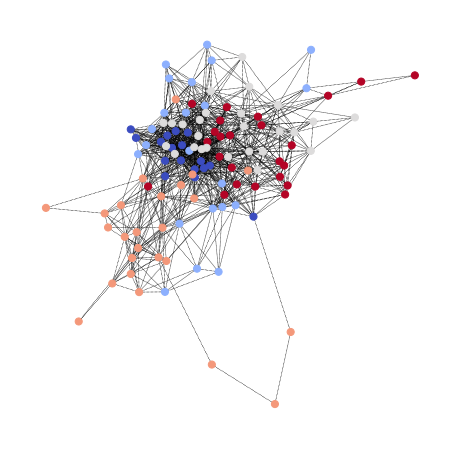

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import dgl 

#train_set = dgl.data.CoraBinary()
#G1, pmpd1, label1 = train_set[1]
G1 = dataset.graph
nx_G1 = G1.to_networkx()
label1 = dataset.labels

def visualize(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=50, cmap=plt.get_cmap('coolwarm'),
                     node_color=labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)
visualize(label1, nx_G1)


In [6]:
##############################################
####### USE FOR STOCHASTIC TRAINING    #######
##############################################

import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F

sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
dataloader = dgl.dataloading.NodeDataLoader(
    dataset.graph, 
    dataset.idx_train, 
    sampler,
    batch_size=1024,
    shuffle=True,
    drop_last=False,
    num_workers=4)

input_nodes, output_nodes, blocks = next(iter(dataloader))
print(blocks)

[Block(num_src_nodes=114, num_dst_nodes=114, num_edges=2222), Block(num_src_nodes=114, num_dst_nodes=68, num_edges=1240)]


In [3]:

node_features = torch.tensor(dataset.graph.ndata["feats"].clone().detach(), dtype=torch.float32)
node_labels = torch.tensor(dataset.graph.ndata['label'].clone().detach(), dtype=torch.uint8)
train_mask = dataset.graph.ndata['train_mask']
valid_mask = dataset.graph.ndata['val_mask']
test_mask = dataset.graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

print(len(node_features))
print(len(node_labels))

114
114


/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [4]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

# Return a list containing features gathered from multiple radius.
import dgl.function as fn
def aggregate_radius(radius, g, z):
    # initializing list to collect message passing result
    z_list = []
    g.ndata['z'] = z
    # pulling message from 1-hop neighbourhood
    g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
    z_list.append(g.ndata['z'])
    for i in range(radius - 1):
        for j in range(2 ** i):
            #pulling message from 2^j neighborhood
            g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
        z_list.append(g.ndata['z'])
    return z_list

    
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

class LGNNCore(nn.Module):
    def __init__(self, in_feats, out_feats, radius):
        super(LGNNCore, self).__init__()
        self.out_feats = out_feats
        self.radius = radius

        self.linear_prev = nn.Linear(in_feats, out_feats)
        self.linear_deg = nn.Linear(in_feats, out_feats)
        self.linear_radius = nn.ModuleList(
                [nn.Linear(in_feats, out_feats) for i in range(radius)])
        self.linear_fuse = nn.Linear(in_feats, out_feats)
        self.bn = nn.BatchNorm1d(out_feats)

    def forward(self, g, feat_a, feat_b, deg, pm_pd):
        # term "prev"
        prev_proj = self.linear_prev(feat_a)
        # term "deg"
        deg_proj = self.linear_deg(deg * feat_a)

        # term "radius"
        # aggregate 2^j-hop features
        hop2j_list = aggregate_radius(self.radius, g, feat_a)
        # apply linear transformation
        hop2j_list = [linear(x) for linear, x in zip(self.linear_radius, hop2j_list)]
        radius_proj = sum(hop2j_list)

        # term "fuse"
        fuse = self.linear_fuse(th.mm(pm_pd, feat_b))

        # sum them together
        result = prev_proj + deg_proj + radius_proj + fuse

        # skip connection and batch norm
        n = self.out_feats // 2
        result = th.cat([result[:, :n], F.relu(result[:, n:])], 1)
        result = self.bn(result)

        return result
class LGNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, radius):
        super(LGNNLayer, self).__init__()
        self.g_layer = LGNNCore(in_feats, out_feats, radius)
        self.lg_layer = LGNNCore(in_feats, out_feats, radius)

    def forward(self, g, lg, x, lg_x, deg_g, deg_lg, pm_pd):
        next_x = self.g_layer(g, x, lg_x, deg_g, pm_pd)
        pm_pd_y = th.transpose(pm_pd, 0, 1)
        next_lg_x = self.lg_layer(lg, lg_x, x, deg_lg, pm_pd_y)
        return next_x, next_lg_x
class LGNN(nn.Module):
    def __init__(self, radius):
        super(LGNN, self).__init__()
        self.layer1 = LGNNLayer(1, 16, radius)  # input is scalar feature
        self.layer2 = LGNNLayer(16, 16, radius)  # hidden size is 16
        self.layer3 = LGNNLayer(16, 16, radius)
        self.linear = nn.Linear(16, 2)  # predice two classes

    def forward(self, g, lg, pm_pd):
        # compute the degrees
        deg_g = g.in_degrees().float().unsqueeze(1)
        deg_lg = lg.in_degrees().float().unsqueeze(1)
        # use degree as the input feature
        x, lg_x = deg_g, deg_lg
        x, lg_x = self.layer1(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        x, lg_x = self.layer2(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        x, lg_x = self.layer3(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        return self.linear(x)

In [5]:
from torch.utils.data import DataLoader
training_loader = DataLoader(dataset,
                             batch_size=1,
                             collate_fn=dataset.collate_fn,
                             drop_last=True)

In [6]:
# Create the model
model = LGNN(radius=3)
# define the optimizer
optimizer = th.optim.Adam(model.parameters(), lr=1e-2)

# A utility function to convert a scipy.coo_matrix to torch.SparseFloat
def sparse2th(mat):
    value = mat.data
    indices = th.LongTensor([mat.row, mat.col])
    tensor = th.sparse.FloatTensor(indices, th.from_numpy(value).float(), mat.shape)
    return tensor

# Train for 20 epochs
for i in range(20):
    all_loss = []
    all_acc = []
    for [g, pmpd, label] in training_loader:
        # Generate the line graph.
        lg = g.line_graph(backtracking=False)
        # Create torch tensors
        pmpd = sparse2th(pmpd)
        label = th.from_numpy(label)

        # Forward
        z = model(g, lg, pmpd)

        # Calculate loss:
        # Since there are only two communities, there are only two permutations
        #  of the community labels.
        loss_perm1 = F.cross_entropy(z, label)
        loss_perm2 = F.cross_entropy(z, 1 - label)
        loss = th.min(loss_perm1, loss_perm2)

        # Calculate accuracy:
        _, pred = th.max(z, 1)
        acc_perm1 = (pred == label).float().mean()
        acc_perm2 = (pred == 1 - label).float().mean()
        acc = th.max(acc_perm1, acc_perm2)
        all_loss.append(loss.item())
        all_acc.append(acc.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    niters = len(all_loss)
    print("Epoch %d | loss %.4f | accuracy %.4f" % (i,
        sum(all_loss) / niters, sum(all_acc) / niters))

DGLError: Invalid key "0". Must be one of the edge types.

In [21]:
from dgl.data import CoraBinary
CoraBinary().graphs[0]

Done loading data into cached files.
Done loading data from cached files.


Graph(num_nodes=474, num_edges=1844,
      ndata_schemes={}
      edata_schemes={})